# RNN Classification Test
Trying to classify the age of an author based on a written blogpost

## 1. Import libraries

In [ ]:
!pip install torchtext==0.4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import re
import os
import time

import torch
import torchtext
from torchtext.datasets import text_classification
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import nltk
import plotly.express as px
from nltk.stem import WordNetLemmatizer
import plotly.graph_objs as go
nltk.download('wordnet')
nltk.download('stopwords')

from collections import defaultdict, OrderedDict, Counter
import operator

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Load and preprocces the dataframe

In [1]:
path = '/content/drive/MyDrive/Language, speech and dialogue processing/blogtext subset.xlt'

In [ ]:
dataset = pd.read_excel(path)
df = pd.DataFrame(dataset)
df = df.drop(['id', 'topic', 'sign', 'age','date'], axis=1)

df = df.groupby('gender').apply(lambda x: x.sample(frac=0.5))


In [ ]:
encoded_gender = []
for gender in df.gender:
  if gender == 'female':
    encoded_gender.append(0)
  if gender == 'male':
    encoded_gender.append(1)

df['gender'] = encoded_gender
df.head()

gender  age                                               text
gender                                                                       
female 461355       0   36  One more thing...  Well actually two. I forgot...
       329951       0   24  Amazing really, I’m sitting here, it’s rather ...
       209126       0   26  Dig if you will, the picture:   &nbsp;   Gem, ...
       610592       0   38          Election day   Local elections in Ital...
       539229       0   17         I'm tired of you pretending like I don'...

In [ ]:
df

gender  age                                               text
gender                                                                       
female 461355       0   36  One more thing...  Well actually two. I forgot...
       329951       0   24  Amazing really, I’m sitting here, it’s rather ...
       209126       0   26  Dig if you will, the picture:   &nbsp;   Gem, ...
       610592       0   38          Election day   Local elections in Ital...
       539229       0   17         I'm tired of you pretending like I don'...
...               ...  ...                                                ...
male   334644       1   25  Sal's Corner 'Niggas'  Since we are venturing ...
       169698       1   25  Italy vs Denmark  14/06/04 KO 2359 --->Defend ...
       309718       1   17  H.P. Lovecraft intrigues me. First of all, he'...
       368692       1   47                  Feel free to email your comments 
       328770       1   15  since i was bored and had nothing to do, i dec...

[338925 rows x 3 columns]

## 3. Create n_grams from the text (Optional)

In [ ]:
# lemmatizing function
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]
    return text

# remove stopwords
def remove_stopwords(text):
    stopword = nltk.corpus.stopwords.words('english')
    text = [word for word in text if word not in stopword]
    return text
    
def tokenize(text):
    wrong_words = ["urllink", "nbsp"]
    tokens = [token for token in text.split(" ") if token != "" and token not in wrong_words]
    return tokens

def lowered(s):
    return s.lower()

def remove_nonalph(s):
      s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)
      return s

def generate_ngrams(s, n):
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[s[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

In [ ]:
df["text"] = df["text"].apply(lowered).apply(remove_nonalph).apply(tokenize)
print(df['text'].iloc[0])
print(df['text'])

['one', 'more', 'thing', 'well', 'actually', 'two', 'i', 'forgot', 'to', 'mention', 'that', 'i', 'stopped', 'by', 'ex', 'place', 'of', 'business', 'sniff', 'yesterday', 'with', 'the', 'spark', 'in', 'tow', 'to', 'introduce', 'her', 'to', 'her', 'god', 'uncle', 'l', 'l', 'and', 'to', 'say', 'howdy', 'to', 'my', 'boyz', 'and', 'i', 'have', 'got', 'to', 'say', 'they', 'were', 'are', 'and', 'will', 'no', 'doubt', 'continue', 'to', 'be', 'the', 'most', 'phenomenal', 'set', 'of', 'mens', 'folk', 'i', 'think', 'i', 've', 'ever', 'laid', 'mine', 'eyes', 'upon', 'i', 'mean', 'they', 'as', 'a', 'group', 'are', 'pretty', 'darn', 'cool', 'but', 'then', 'they', 'also', 'individually', 'manage', 'to', 'be', 'completely', 'stellar', 'as', 'well', 'tony', 'in', 'particular', 'is', 'noteworthy', 'mostly', 'because', 'he', 's', 'approaching', 'the', 'big', '3', '0', 'which', 'is', 'just', 'sad', 'but', 'also', 'because', 'he', 'holds', 'claim', 'to', 'being', 'the', 'only', 'boy', 'i', 've', 'ever', 'me

In [ ]:
df.index = range(len(df))


Pre processing data loader

In [ ]:
class_choice = 'gender'
classdict = defaultdict(int)

for row in df[class_choice]:
  classdict[row] += 1
print(sorted(classdict))

### PROBLEM: ALS IK DIT WISSEL NAAR NORMAL SORT DAN IS DE UITKOMST INEENS ANDERS???
classdict = dict(sorted(classdict.items(), key=operator.itemgetter(1), reverse=True))
#classdict = dict(sorted(classdict.items()))
print('classdict:')
print(classdict)

[0, 1]
classdict:
{1: 171655, 0: 167270}


## 7. Vocabulary dictionary
Making a dict of all the words in the dataset and mapping each unique word to a unique number

In [ ]:
vocabdict = defaultdict(int)   

for row in df['text']:
  for n_gram in row:
    n_gram = n_gram.lower()
    vocabdict[n_gram] += 1

vocabdict = dict(sorted(vocabdict.items(), key=operator.itemgetter(1), reverse=True))
print(vocabdict)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# WORD TO NUMBER MAPPING
l = list(vocabdict.keys())
wordmap = dict([(y,x) for x,y in enumerate(l)])
print(wordmap)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## 8. Mapping text column to numbers (tensor)

In [ ]:
import numpy as np
text_int_list = []
text_lengths = []
for i, text in enumerate(df['text']):
  newtext = []
  lens = []
  for word in text:
    newtext.append(int(wordmap[word]))
  text_lengths.append(len(newtext))
  text_int_list.append(newtext)
average_len = int(sum(text_lengths) / len(text_lengths))
df["lengths"] = text_lengths

encoding_padded = []
for ints in text_int_list:
  N = average_len
  zeros = np.zeros(N, dtype=int)
  encoded = zeros
  length = min(N, len(ints))
  encoded[:length] = ints[:length]
  encoding_padded.append(np.array((encoded, len(ints))))

df["encoded"] = encoding_padded
df



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



,gender,age,text,lengths,encoded
0,0,36,"[one, more, thing, well, actually, two, i, for...",304,"[[41, 65, 129, 70, 181, 144, 0, 970, 2, 920, 7..."
1,0,24,"[amazing, really, i, m, sitting, here, it, s, ...",230,"[[642, 59, 0, 33, 535, 91, 6, 12, 417, 456, 59..."
2,0,26,"[dig, if, you, will, the, picture, gem, grey, ...",565,"[[3312, 42, 11, 51, 1, 580, 8453, 3154, 156740..."
3,0,38,"[election, day, local, elections, in, italy, t...",40,"[[1552, 83, 967, 3867, 8, 3992, 20, 341, 316, ..."
4,0,17,"[i, m, tired, of, you, pretending, like, i, do...",13,"[[0, 33, 415, 5, 11, 4528, 30, 0, 60, 15, 1944..."
...,...,...,...,...,...
338920,1,25,"[sal, s, corner, niggas, since, we, are, ventu...",552,"[[13862, 12, 1390, 17430, 167, 23, 31, 22495, ..."
338921,1,25,"[italy, vs, denmark, 14, 06, 04, ko, 2359, def...",251,"[[3992, 2053, 11999, 982, 3235, 1658, 1289, 83..."
338922,1,17,"[h, p, lovecraft, intrigues, me, first, of, al...",153,"[[1286, 410, 40289, 28118, 17, 120, 5, 28, 26,..."
338923,1,47,"[feel, free, to, email, your, comments]",6,"[[135, 349, 2, 613, 62, 742, 0, 0, 0, 0, 0, 0,..."


In [ ]:
X = list(df['encoded'])
y = list(df['gender'])
print(X[0])
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

[array([   41,    65,   129,    70,   181,   144,     0,   970,     2,
         920,     7,     0,   877,    58,  1256,   210,     5,   711,
        5978,   305,    21,     1,  6514,     8,  8432,     2,  4802,
          50,     2,    50,   183,  1623,  1008,  1008,     3,     2,
         108, 10709,     2,     9, 14967,     3,     0,    22,    77,
           2,   108,    34,    76,    31,     3,    51,    61,  1085,
         944,     2,    24,     1,   146, 10933,   409,     5, 16932,
        4253,     0,    69,     0,    86,   158,  2013,   546,   383,
         681,     0,   231,    34,    29,     4,   459,    31,   188,
        3038,   263,    18,    56,    34,   130, 10179,  2040,     2,
          24,   622, 11137,    29,    70,  2514,     8,  1263,    10,
       18629,   977,    82,    26,    12,  5278,     1,   222,   170,
         824,    89,    10,    32,   464,    18,   130,    82,    26,
        2995,  2034,     2,   134,     1,    88,   493,     0,    86,
         158,   499

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import spacy
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class BlogDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [ ]:
train_ds = BlogDataset(X_train, y_train)
valid_ds = BlogDataset(X_valid, y_valid)

**TO-DO:**

*   Confusion matrix
*   Activation words





In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# confusion matrix plot function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Language, speech and dialogue processing/gender_Blog_rnn_confusion_matrix.png')
    

In [ ]:
def train_model(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.long().to(device)
            y = y.long().to(device)
            l = l.to(device)
            y_pred = model(x, l)
            optimizer.zero_grad()
            x, y, l = x.to(device), y.to(device), l.to(device)
            loss = F.cross_entropy(y_pred, y).to(device)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_rmse = validation_metrics(model, val_dl)
        train_loss = sum_loss/total
        print('Epoch: %d' %(i + 1))
        print(f'\tLoss: {train_loss:.4f}(train)\t')
        print(f'\tLoss: {val_loss:.4f}(valid)\t|\tAcc: {val_acc * 100:.1f}%(valid) | \tRMSE: {val_rmse * 100:.1f}(valid)')
        if i == (epochs-1):
          predictions, labels = validation_metrics(model, val_dl, True)
          conf_matrix = confusion_matrix(np.array(labels), np.array(predictions), labels=[0, 1])
          np.set_printoptions(precision=2)
          # Plot non-normalized confusion matrix
          #plt.figure()
          plot_confusion_matrix(conf_matrix, classes=['female', 'male'], normalize=True, title='gender Blog RNN Confusion matrix, with normalization')



def validation_metrics (model, valid_dl, last_epoch=False):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    predictions = []
    labels = []
    for x, y, l in valid_dl:
        x,y,l = x.to(device), y.to(device), l.to(device)
        x = x.long()
        y = y.long()
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(1)
        predict = pred.to('cpu')
        label = y.to('cpu')
        predictions.extend(predict)
        labels.extend(label)
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred.cpu(), y.unsqueeze(-1).cpu()))*y.shape[0]
    if last_epoch == False:
      return sum_loss/total, correct/total, sum_rmse/total
    else:
      return predictions, labels



In [ ]:
batch_size = 256
vocab_size = len(vocabdict)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

In [ ]:
class LSTM_fixed_len(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [ ]:
print(f"Vocab size: {vocab_size}")

# Rule of thumb voor embed dim volgens: 
# (https://datascience.stackexchange.com/questions/31109/ratio-between-embedded-vector-dimensions-and-vocabulary-size)

embedding_dimensions =  int(vocab_size**0.25)

model_fixed =  LSTM_fixed_len(vocab_size, embedding_dimensions, 50).to(device)

Vocab size: 454585


Epoch: 1
	Loss: 0.6717(train)	
	Loss: 0.6268(valid)	|	Acc: 64.9%(valid) | 	RMSE: 59.2(valid)
Epoch: 2
	Loss: 0.5776(train)	
	Loss: 0.5738(valid)	|	Acc: 69.7%(valid) | 	RMSE: 55.0(valid)
Epoch: 3
	Loss: 0.5020(train)	
	Loss: 0.5770(valid)	|	Acc: 70.0%(valid) | 	RMSE: 54.7(valid)
Epoch: 4
	Loss: 0.4396(train)	
	Loss: 0.6129(valid)	|	Acc: 69.1%(valid) | 	RMSE: 55.5(valid)
Epoch: 5
	Loss: 0.3883(train)	
	Loss: 0.6324(valid)	|	Acc: 68.7%(valid) | 	RMSE: 55.9(valid)
Epoch: 6
	Loss: 0.3462(train)	
	Loss: 0.6843(valid)	|	Acc: 68.7%(valid) | 	RMSE: 55.9(valid)
Epoch: 7
	Loss: 0.3141(train)	
	Loss: 0.7214(valid)	|	Acc: 68.7%(valid) | 	RMSE: 55.9(valid)
Epoch: 8
	Loss: 0.2893(train)	
	Loss: 0.7481(valid)	|	Acc: 68.6%(valid) | 	RMSE: 56.0(valid)
Epoch: 9
	Loss: 0.2687(train)	
	Loss: 0.8033(valid)	|	Acc: 68.1%(valid) | 	RMSE: 56.5(valid)
Epoch: 10
	Loss: 0.2546(train)	
	Loss: 0.8486(valid)	|	Acc: 67.5%(valid) | 	RMSE: 56.9(valid)
Epoch: 11
	Loss: 0.2411(train)	
	Loss: 0.8836(valid)	|	Acc: 67.9%(val

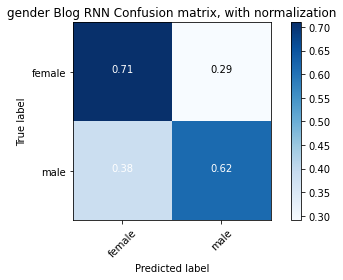

In [ ]:

train_model(model_fixed, epochs=50, lr=0.01)